# Explore DESeq2 output & normalize IME to intronless

In [40]:
from datetime import date
print('created 2024-04-24')
print("last updated", date.today())

created 2024-04-24
last updated 2024-06-06


In [41]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 150

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'

In [42]:
# load in barcode-to-intron dictionary
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters_10trustworthy.pkl', 'rb') as f:
    b2i = pickle.load(f)

In [43]:
# import table of read counts and DESeq outputs
RIL12 = pd.read_csv(outpath+'data/integrated_GFP_dTom_counts_with_unspliced.csv', index_col=0)
norm_cts = pd.read_csv(outpath+"data/integrated_DESeq2_output_norm_cts.csv", index_col=0)
shrunk_results = pd.read_csv(outpath+"data/integrated_DESeq2_output_shrunk_results.csv", index_col=0)

# filter to trusted barcodes only
RIL12 = RIL12[RIL12.index.isin(b2i)]
bcs = list(RIL12.index)

df=RIL12.copy()
for col in shrunk_results.columns:
    df[f"{col}"]=shrunk_results[col].values

# padj cutoff used when DESeq was run
p_cutoff = 0.1

sig = df['padj'].values<p_cutoff

with (open(outpath+"pkls/RIL12only_b2i06min3readclusters_10percentMM_4sampfilter_DESeq2_output.pkl",'wb')) as f:
    pickle.dump(df,f)

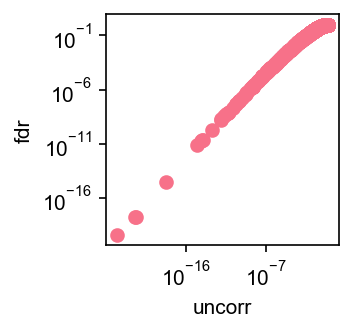

In [44]:
plt.figure(figsize=(2,2))
plt.scatter(df['uncorr_pval'],df['padj'])
plt.xlabel('uncorr')
plt.ylabel('fdr')
plt.xscale('log')
plt.yscale('log')

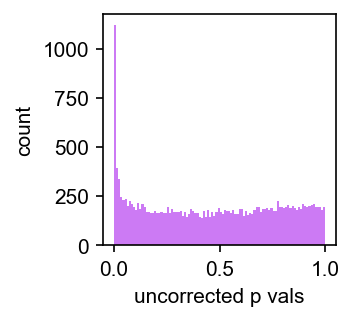

In [45]:
plt.figure(figsize=(2,2))
plt.hist(df['uncorr_pval'], bins=100, facecolor=nicecolors(4))
plt.xlabel('uncorrected p vals')
plt.ylabel('count')
plt.show()

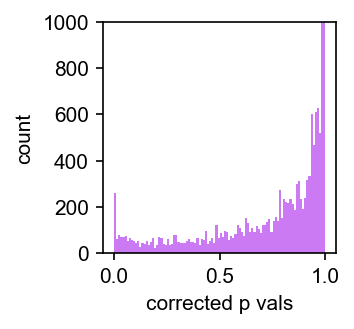

In [46]:
plt.figure(figsize=(2,2))
plt.hist(df['padj'], bins=100, facecolor=nicecolors(4))
plt.xlabel('corrected p vals')
plt.ylabel('count')
plt.ylim(0,1000)
plt.show()

In [47]:
num_reps=10
GFP_counts = norm_cts.values[:,:num_reps]    # includes unspliced!!
dTom_counts = norm_cts.values[:,num_reps:num_reps*2]

raw_IME_scores = np.log2((1+GFP_counts)/(1+dTom_counts))
l2fc = df.PosteriorMean
l2fc_SD = df.PosteriorSD
readcounts = GFP_counts + dTom_counts

intronless_barcodes = ['ACTATCTAACCAAACACA', 
                       'ACTCCTTCAATCCCATCA',
                       'CATAACTTAATTATTTTA',
                       'TACATTATCTCTTCATAC']

UbC_bc = 'ATACCATAACTACCCACT'
spike_in_bcs = intronless_barcodes+[UbC_bc]

intless_mask = [b in intronless_barcodes for b in bcs]
pos_ctrl_mask = [b==UbC_bc for b in bcs]

In [48]:
len(GFP_counts)

19346

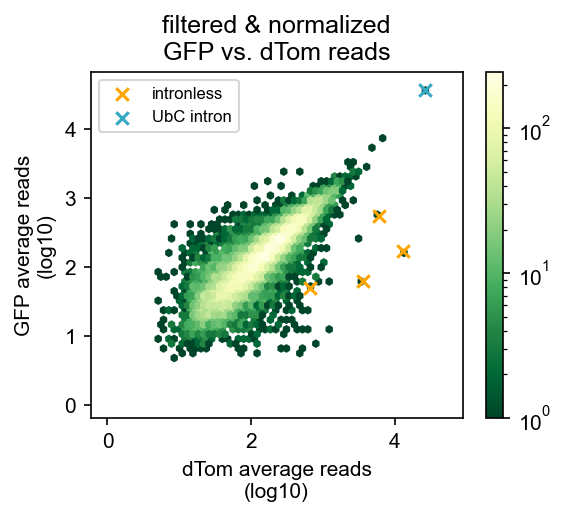

In [49]:
fig = plt.figure(figsize=(4,3))

xdata = np.log10(1+dTom_counts.mean(1))
ydata = np.log10(1+GFP_counts.mean(1))
                 
hb = plt.hexbin(xdata, ydata,  cmap='YlGn_r',
                gridsize=50, bins='log') 

for msk, col, name in [(intless_mask, 'orange', 'intronless'), 
                       (pos_ctrl_mask, nicecolors(3), 'UbC intron')]:                
    plt.scatter(xdata[msk], ydata[msk],
               marker='x', color=col, label=name)
    
#plt.plot([1, 5], [1, 5], c='k', linestyle='--', linewidth=1)

plt.ylabel('GFP average reads\n(log10)')
plt.xlabel('dTom average reads\n(log10)')
plt.title('filtered & normalized\nGFP vs. dTom reads')
plt.legend(loc=2, fontsize=8)
cb = fig.colorbar(hb, #label='density'
                 )

plt.xlim((-0.23559715406086676, 4.947540131615456))
plt.ylim((-0.1869156319323457, 4.835867344060212))
plt.show()

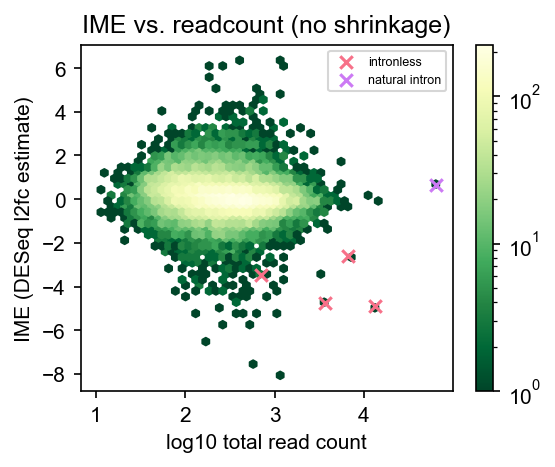

In [50]:
fig = plt.figure(figsize=(4,3))

xdata = np.log10(readcounts.mean(1))
ydata = df.uncorr_log2FC

hb = plt.hexbin(xdata, ydata, cmap='YlGn_r',
                gridsize=50, bins='log') 

for msk, col, name in [(intless_mask, nicecolors(0), 'intronless'), (pos_ctrl_mask, nicecolors(4), 'natural intron')]:                
    plt.scatter(xdata[msk], ydata[msk],
               marker='x', color=col, label=name)

plt.xlabel('log10 total read count')
plt.ylabel('IME (DESeq l2fc estimate)')
plt.title('IME vs. readcount (no shrinkage)')

plt.legend(loc=1, fontsize=6)
cb = fig.colorbar(hb, #label='density'
                 )

In [72]:
#sig = df['padj'].values<p_cutoff
sig = df['padj'].values<0.05
pos = df['PosteriorMean'].values>1.
neg = df['PosteriorMean'].values<-1.
#pos = df['PosteriorMean'].values>0
#neg = df['PosteriorMean'].values<0

significant = sig & (pos|neg)
non_significant = ~significant

up_ints = [b2i[b] for b in df[sig&pos].index]
down_ints = [b2i[b] for b in df[sig&neg].index]

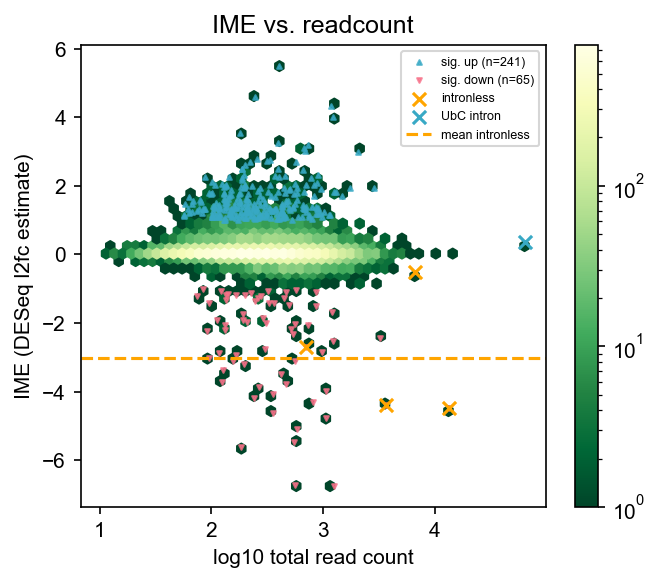

In [73]:
fig = plt.figure(figsize=(5,4))

i_msk = np.array(intless_mask)
intless_baseline = l2fc[i_msk].mean()
norm_l2fc = np.array(l2fc-intless_baseline)

xdata = np.log10(readcounts.mean(1))
ydata = l2fc

hb = plt.hexbin(xdata, ydata, cmap='YlGn_r', 
                gridsize=50, bins='log') 

#for msk, col, name in [(intless_mask, nicecolors(0), 'intronless'), (pos_ctrl_mask, nicecolors(4), 'natural intron')]:                
#    plt.scatter(xdata[msk], ydata[msk],
#               marker='x', color=col, label=name)

for msk, col, name, sz, alph, mrk in [#(non_significant, 'grey', 'non-sig.', 1, 0.2, 'o'),
                                      (sig&pos, nicecolors(3), f'sig. up (n={np.sum(sig&pos)})', 5, 0.8, '^'),
                                      (sig&neg, nicecolors(0), f'sig. down (n={np.sum(sig&neg)})', 5, 0.8,  'v'),
                                      (intless_mask, 'orange', 'intronless', 40, 1, 'x'), 
                                      (pos_ctrl_mask, nicecolors(3), 'UbC intron', 40, 1, 'x')]:                
    plt.scatter(xdata[msk], ydata[msk], s=sz, alpha=alph, marker=mrk, color=col, label=name)

plt.xlabel('log10 total read count')
plt.ylabel('IME (DESeq l2fc estimate)')
plt.title('IME vs. readcount') #(with shrinkage)')
plt.axhline(intless_baseline, linestyle='--', label='mean intronless', c='orange')

plt.legend(loc=1, fontsize=6)
cb = fig.colorbar(hb, #label='density'
                 )

plt.show()

In [74]:
sorted_df = df.sort_values('PosteriorMean')
intless = np.array([x in intronless_barcodes for x in sorted_df.index])

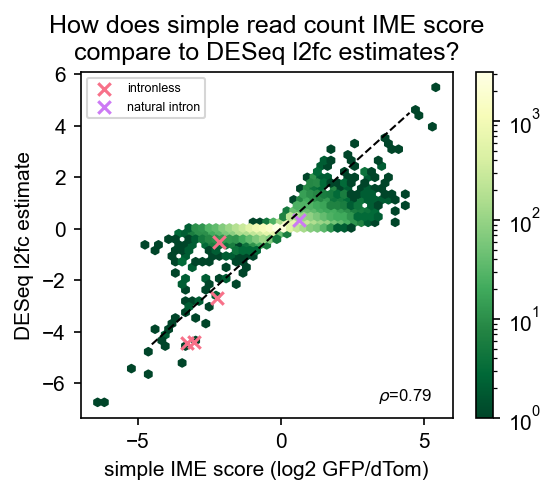

In [75]:
fig = plt.figure(figsize=(4,3))

xdata = raw_IME_scores.mean(1)
ydata = l2fc

iub = (sorted_df.PosteriorSD[intless]).mean()
ilb = (-sorted_df.PosteriorSD[intless]).mean()

hb = plt.hexbin(xdata, ydata, cmap='YlGn_r',
                gridsize=50, bins='log') 

for msk, col, name in [(intless_mask, nicecolors(0), 'intronless'), (pos_ctrl_mask, nicecolors(4), 'natural intron')]:                
    plt.scatter(xdata[msk], ydata[msk],
               marker='x', color=col, label=name)

plt.plot([-4.5, 4.5], [-4.5, 4.5], c='k', linestyle='--', linewidth=1)
coef, _ = stats.spearmanr(xdata,ydata)
plt.annotate(f'$\\rho$={coef:.2f}', xy=(0.8, 0.05), xycoords='axes fraction', fontsize=8)
    

plt.xlabel('simple IME score (log2 GFP/dTom)')
plt.ylabel('DESeq l2fc estimate')
plt.title('How does simple read count IME score\ncompare to DESeq l2fc estimates?')

plt.legend(loc=2, fontsize=6)
cb = fig.colorbar(hb, #label='density'
                 )

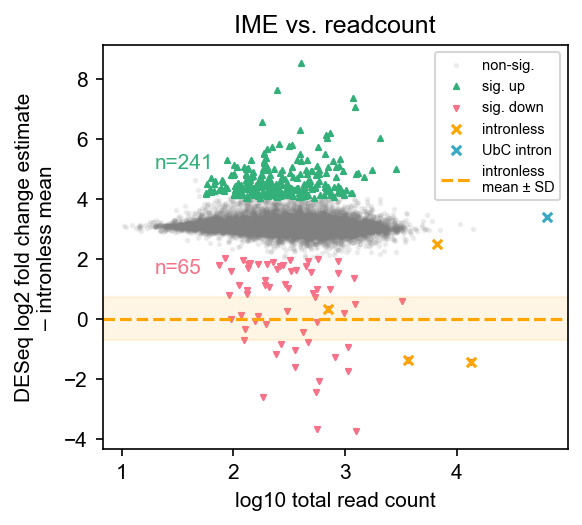

In [85]:
fig = plt.figure(figsize=(4,3.5))

xdata = np.log10(readcounts.mean(1))
ydata = norm_l2fc

for msk, col, name, sz, alph, mrk in [(non_significant, 'grey', 'non-sig.', 3, 0.1, 'o'),
                                      (sig&pos, nicecolors(2), f'sig. up', 6, 1, '^'),
                                      (sig&neg, nicecolors(0), f'sig. down', 6, 1,  'v'),
                                      (intless_mask, 'orange', 'intronless', 20, 1, 'x'), 
                                      (pos_ctrl_mask, nicecolors(3), 'UbC intron', 20, 1, 'x')]:                  
    plt.scatter(xdata[msk], ydata[msk], s=sz, alpha=alph, marker=mrk, color=col, label=name)

plt.xlabel('log10 total read count')
plt.ylabel('DESeq log2 fold change estimate\n– intronless mean')
plt.title('IME vs. readcount') #(with shrinkage)')

iub = (sorted_df.PosteriorSD[intless]).mean()
ilb = (-sorted_df.PosteriorSD[intless]).mean()
plt.axhline(0, linestyle='--', c='orange', label='intronless\nmean ± SD')
plt.axhspan(ilb, iub, color='orange', alpha=0.1)
plt.annotate(f'n={np.sum(sig&pos)}', c= nicecolors(2), xy=(1.3,5))
plt.annotate(f'n={np.sum(sig&neg)}', c= nicecolors(0), xy=(1.3,1.5))

plt.legend(loc=1, fontsize=7)

plt.show()

## normalize IME scores to intronless l2fc

In [57]:
i_msk = np.array(intless_mask)
intless_log_mean = l2fc[i_msk].mean()
intless_log_SD = np.std(l2fc[i_msk])

intless_nat_mean = 2**intless_log_mean
intless_nat_upper_bound = 2**(intless_log_mean+intless_log_SD)
intless_nat_lower_bound = 2**(intless_log_mean-intless_log_SD)

lib_log_mean = np.mean(norm_l2fc[~i_msk])
lib_log_SD = np.std(norm_l2fc[~i_msk])

lib_nat_mean = 2**lib_log_mean
lib_nat_upper_bound = 2**(lib_log_mean+lib_log_SD)
lib_nat_lower_bound = 2**(lib_log_mean-lib_log_SD)

lib_log_median = np.median(norm_l2fc[~i_msk])
lib_nat_median = 2**lib_log_median
lib_log_975, lib_log_25 = np.percentile(norm_l2fc[~i_msk], 97.5), np.percentile(norm_l2fc[~i_msk], 2.5)
lib_nat_975, lib_nat_25 = 2**lib_log_975, 2**lib_log_25

print(f'The estimated effect of an intronless barcode')
print(f'is to decrease GFP expresion to {intless_nat_mean:.2f}X (2SD: {intless_nat_lower_bound:.2f} - {intless_nat_upper_bound:.2f}) compared to the mean of the library,')

#mean_original, std_original = log2_to_original(np.mean(norm_l2fc[~i_msk]), np.std(norm_l2fc[~i_msk]))
print(f'\nIn other words, compared to an intronless GFP,')
print(f'the average intron in the library increases GFP expression {lib_nat_mean:.2f}X (2SD: {lib_nat_lower_bound:.2f} - {lib_nat_upper_bound:.2f}).')
print(f'library median: {lib_nat_median:.2f}\n95%CI: ({lib_nat_25:.2f}-{lib_nat_975:.2f})')

The estimated effect of an intronless barcode
is to decrease GFP expresion to 0.12X (2SD: 0.04 - 0.38) compared to the mean of the library,

In other words, compared to an intronless GFP,
the average intron in the library increases GFP expression 8.55X (2SD: 6.87 - 10.64).
library median: 8.44
95%CI: (6.51-13.36)


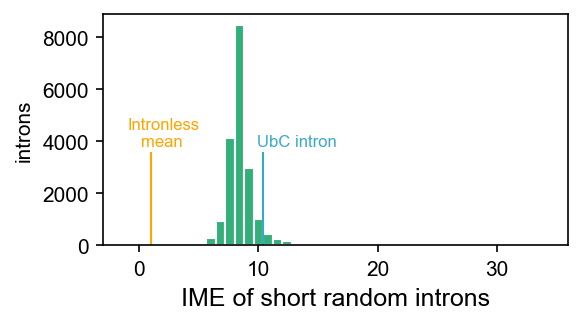

In [58]:
plt.figure(figsize=(4,2))
#plt.hist([x for x in 2**norm_l2fc if x<10], bins=30, edgecolor='w', facecolor=nicecolors(4))
plt.hist([2**x for x in norm_l2fc if x<4], bins=20, 
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('IME of short random introns', fontsize=12)
plt.ylabel('introns')
#marks = [1, 2.5, 5, 7.5, 10, 12.5, 15]
#plt.xticks((marks),[str(x) for x in marks])

UbC_fc = 2**(df.loc[UbC_bc,'PosteriorMean']-intless_baseline)
plt.axvline(UbC_fc, c=nicecolors(3), ymin=0, ymax=0.4, linewidth=1)
plt.annotate('UbC intron',xy=(UbC_fc-0.5,3800), fontsize=8, c=nicecolors(3))

plt.axvline(1, c='orange', ymin=0, ymax=0.4, linewidth=1)
plt.annotate('Intronless\n   mean',xy=(-1,3800), fontsize=8, c='orange')

plt.xlim(-3, 36)
plt.show()

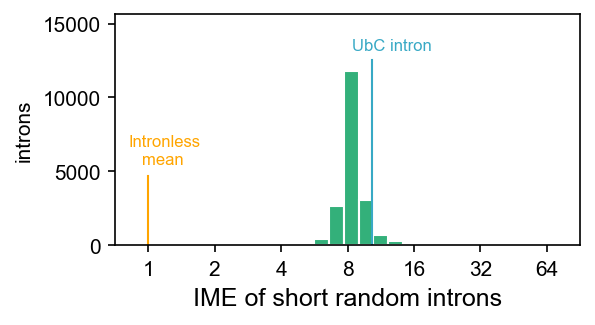

In [61]:
plt.figure(figsize=(4,2))
#plt.hist([x for x in 2**norm_l2fc if x<10], bins=30, edgecolor='w', facecolor=nicecolors(4))
plt.hist([x for x in norm_l2fc], bins=55, 
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('IME of short random introns', fontsize=12)
plt.ylabel('introns')

marks = np.array([1, 2, 4, 8, 16, 32, 64])
plt.xticks(np.log2(marks),[str(x) for x in marks])

UbC_fc = (df.loc[UbC_bc,'PosteriorMean']-intless_baseline)
plt.axvline(UbC_fc, c=nicecolors(3), ymin=0, ymax=0.8, linewidth=1)
plt.annotate('UbC intron',xy=(UbC_fc-0.3,13200), fontsize=8, c=nicecolors(3))

plt.axvline(0, c='orange', ymin=0, ymax=0.3, linewidth=1)
plt.annotate('Intronless\n   mean',xy=(-0.3,5500), fontsize=8, c='orange')

plt.ylim(0,15650)
plt.xlim(-0.5, 6.5)
plt.show()

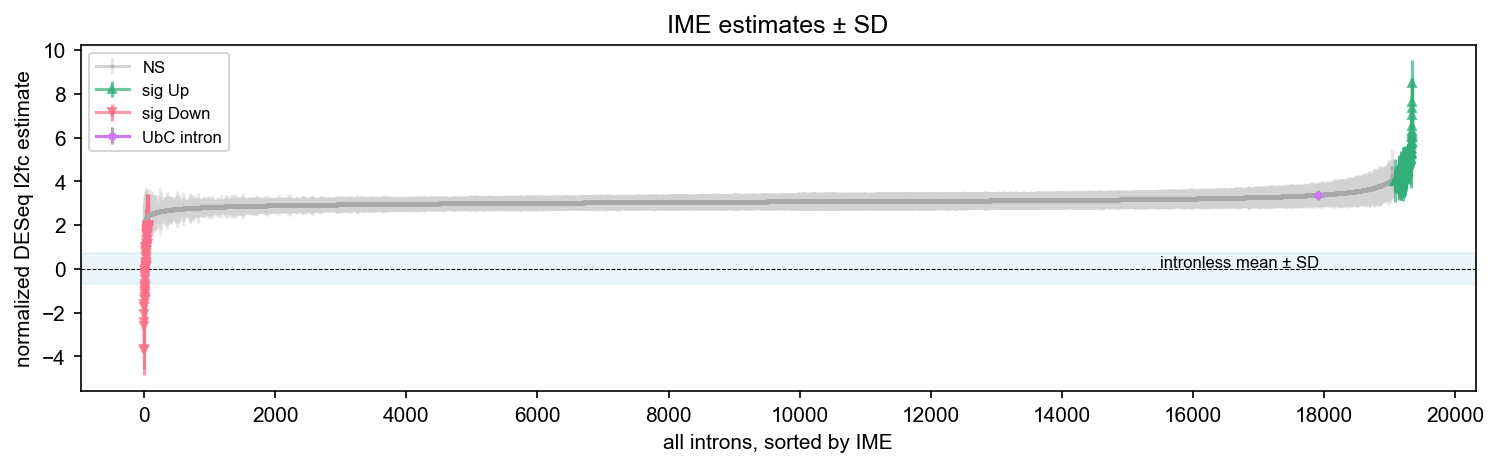

In [60]:
sorted_df = df.sort_values('PosteriorMean')

sig = sorted_df.padj<0.05
pos = sorted_df.PosteriorMean>1.
neg = sorted_df.PosteriorMean<-1.
nonsig = sorted_df.index[(~sig)|((~pos)&(~neg))]
UbC = sorted_df.index==UbC_bc
intless = np.array([x in intronless_barcodes for x in sorted_df.index])

sorted_df['NormPosteriorMean'] = sorted_df.PosteriorMean-intless_baseline

plt.figure(figsize=(12,3))
plt.errorbar([i for i, v in enumerate(nonsig) if v], 
             sorted_df.NormPosteriorMean[nonsig], 
             yerr=sorted_df.PosteriorSD[nonsig], 
             ecolor='lightgray', alpha=0.5, marker='o', c='darkgrey', markersize=1, label='NS')

plt.errorbar([i for i, v in enumerate(sig&pos) if v], 
             sorted_df.NormPosteriorMean[sig&pos], 
             yerr=sorted_df.PosteriorSD[sig&pos], 
             alpha=0.7, marker = '^', c=nicecolors(2), markersize=4, label='sig Up')

plt.errorbar([i for i, v in enumerate(sig&neg) if v], 
             sorted_df.NormPosteriorMean[sig&neg], 
             yerr=sorted_df.PosteriorSD[sig&neg], 
             alpha=0.7, marker = 'v', c=nicecolors(0), markersize=4, label='sig Down')

plt.errorbar([i for i, v in enumerate(UbC) if v], 
             sorted_df.NormPosteriorMean[UbC], 
             yerr=sorted_df.PosteriorSD[UbC], 
             ecolor='darkgrey', alpha=1, marker = '.', c=nicecolors(4), label='UbC intron')

iub = (sorted_df.PosteriorSD[intless]).mean()
ilb = (-sorted_df.PosteriorSD[intless]).mean()

plt.axhline(0, c='k',linestyle='--',linewidth=0.5)
plt.axhspan(ilb, iub, color=nicecolors(3), alpha=0.1)
plt.annotate('intronless mean ± SD', xy=(15500,0.08), fontsize=8)

plt.xlabel('all introns, sorted by IME')
plt.ylabel('normalized DESeq l2fc estimate')
plt.title('IME estimates ± SD')
plt.xticks(np.arange(0,22000,2000))
plt.legend(fontsize=8)
plt.show()